# Structuration du corpus

In [2]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [1]:
# Exercice 4 : Structuration du corpus
# M2 MALIA-MIASHS : projet Network Analysis for Information Retrieval

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
from collections import Counter
import re
import time
import os
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn pour le traitement de texte, clustering et évaluation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import normalize, StandardScaler

# NLTK pour le prétraitement
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Gensim pour Doc2Vec et LDA
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2dense

# Téléchargement des ressources NLTK nécessaires
nltk.download('punkt')
nltk.download('stopwords')

# Configuration pour un meilleur affichage
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#===========================================================================================
# 1. Chargement et préparation des données
#===========================================================================================

def load_processed_data(file_path):
    """
    Charge les données traitées lors des exercices précédents.

    Args:
        file_path (str): Chemin du fichier pickle contenant le DataFrame

    Returns:
        pandas.DataFrame: DataFrame contenant les articles
    """
    try:
        df = pd.read_pickle(file_path)
        print(f"Données chargées avec succès. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Erreur lors du chargement des données: {e}")
        return None

def prepare_texts_for_clustering(df):
    """
    Prépare les textes pour le clustering en combinant titre et résumé.

    Args:
        df (pandas.DataFrame): DataFrame contenant les articles

    Returns:
        pandas.DataFrame: DataFrame avec texte combiné
    """
    df = df.copy()

    # Vérifier si la colonne 'combined_text' existe déjà
    if 'combined_text' not in df.columns:
        # Combiner le titre et le résumé
        df['combined_text'] = df.apply(
            lambda row: f"{row['title']} {row['abstract'] if pd.notna(row['abstract']) else ''}",
            axis=1
        )

    return df

#===========================================================================================
# 2. Vectorisation des documents - Différentes représentations vectorielles
#===========================================================================================

class VectorRepresentation:
    """Classe pour générer différentes représentations vectorielles du corpus."""

    def __init__(self, df, text_column='combined_text'):
        """
        Initialise la classe avec le DataFrame d'articles.

        Args:
            df (pandas.DataFrame): DataFrame contenant les articles
            text_column (str): Nom de la colonne contenant le texte
        """
        self.df = df
        self.text_column = text_column
        self.texts = df[text_column].tolist()
        self.stop_words = stopwords.words('english')

        # Ajout de stop words spécifiques au domaine scientifique
        scientific_stop_words = [
            'doi', 'fig', 'figure', 'et', 'al', 'paper', 'study', 'research',
            'method', 'results', 'analysis', 'data', 'proposed', 'approach',
            'using', 'based', 'used', 'show', 'shown', 'table', 'section'
        ]
        self.stop_words.extend(scientific_stop_words)

        # Préprocesseur et tokenizer pour scikit-learn
        self.stemmer = PorterStemmer()

        # Résultats des différentes vectorisations
        self.vector_representations = {}
        self.vectorizers = {}

    def preprocess_text(self, text):
        """
        Prétraite un texte (minuscules, retrait ponctuation, etc.)

        Args:
            text (str): Texte à prétraiter

        Returns:
            str: Texte prétraité
        """
        # Conversion en minuscules
        text = text.lower()

        # Suppression des chiffres et de la ponctuation
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', ' ', text)

        # Suppression des espaces multiples
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def tokenize_and_stem(self, text):
        """
        Tokenise et applique le stemming au texte.

        Args:
            text (str): Texte à tokeniser

        Returns:
            list: Liste de stems
        """
        words = word_tokenize(text)
        return [self.stemmer.stem(word) for word in words if word not in self.stop_words]

    def create_tfidf_vectors(self, min_df=5, max_df=0.95, max_features=None):
        """
        Crée les vecteurs TF-IDF pour les documents.

        Args:
            min_df (int): Fréquence minimale des termes
            max_df (float): Fréquence maximale des termes
            max_features (int): Nombre maximum de features

        Returns:
            scipy.sparse.csr_matrix: Matrice documents-termes
        """
        print("Création des vecteurs TF-IDF...")

        # Création du vectoriseur
        tfidf_vectorizer = TfidfVectorizer(
            preprocessor=self.preprocess_text,
            tokenizer=self.tokenize_and_stem,
            min_df=min_df,
            max_df=max_df,
            max_features=max_features,
            ngram_range=(1, 1)
        )

        # Transformation des documents
        tfidf_matrix = tfidf_vectorizer.fit_transform(self.texts)

        # Enregistrement des résultats
        self.vector_representations['tfidf'] = tfidf_matrix
        self.vectorizers['tfidf'] = tfidf_vectorizer

        print(f"Matrice TF-IDF: {tfidf_matrix.shape[0]} documents × {tfidf_matrix.shape[1]} termes")

        return tfidf_matrix

    def create_count_vectors(self, min_df=5, max_df=0.95, max_features=None):
        """
        Crée les vecteurs Count (TF) pour les documents.

        Args:
            min_df (int): Fréquence minimale des termes
            max_df (float): Fréquence maximale des termes
            max_features (int): Nombre maximum de features

        Returns:
            scipy.sparse.csr_matrix: Matrice documents-termes
        """
        print("Création des vecteurs TF (Count)...")

        # Création du vectoriseur
        count_vectorizer = CountVectorizer(
            preprocessor=self.preprocess_text,
            tokenizer=self.tokenize_and_stem,
            min_df=min_df,
            max_df=max_df,
            max_features=max_features,
            ngram_range=(1, 1)
        )

        # Transformation des documents
        count_matrix = count_vectorizer.fit_transform(self.texts)

        # Enregistrement des résultats
        self.vector_representations['count'] = count_matrix
        self.vectorizers['count'] = count_vectorizer

        print(f"Matrice Count: {count_matrix.shape[0]} documents × {count_matrix.shape[1]} termes")

        return count_matrix

    def create_doc2vec_vectors(self, vector_size=100, min_count=2, epochs=20):
        """
        Crée les vecteurs Doc2Vec pour les documents.

        Args:
            vector_size (int): Dimension des vecteurs
            min_count (int): Fréquence minimale des termes
            epochs (int): Nombre d'itérations d'entraînement

        Returns:
            numpy.ndarray: Matrice documents-vecteurs
        """
        print("Création des vecteurs Doc2Vec...")

        # Prétraitement des textes
        processed_texts = []
        for i, text in enumerate(self.texts):
            text = self.preprocess_text(text)
            words = word_tokenize(text)
            words = [word for word in words if word not in self.stop_words]
            processed_texts.append(TaggedDocument(words=words, tags=[i]))

        # Création et entraînement du modèle
        model = Doc2Vec(
            processed_texts,
            vector_size=vector_size,
            min_count=min_count,
            workers=4,
            epochs=epochs
        )

        # Création de la matrice de vecteurs
        doc_vectors = np.zeros((len(self.texts), vector_size))
        for i in range(len(self.texts)):
            doc_vectors[i] = model.dv[i]

        # Enregistrement des résultats
        self.vector_representations['doc2vec'] = doc_vectors
        self.vectorizers['doc2vec'] = model

        print(f"Matrice Doc2Vec: {doc_vectors.shape[0]} documents × {doc_vectors.shape[1]} dimensions")

        return doc_vectors

    def create_lda_vectors(self, num_topics=20, chunksize=2000, passes=20, min_df=5, max_df=0.95):
        """
        Crée les vecteurs LDA (thématiques) pour les documents.

        Args:
            num_topics (int): Nombre de thématiques à extraire
            chunksize (int): Taille des batchs pour l'entraînement
            passes (int): Nombre de passes d'entraînement
            min_df (int): Fréquence minimale des termes
            max_df (float): Fréquence maximale des termes

        Returns:
            numpy.ndarray: Matrice documents-thématiques
        """
        print("Création des vecteurs LDA (thématiques)...")

        # Prétraitement des textes
        processed_texts = []
        for text in self.texts:
            text = self.preprocess_text(text)
            words = word_tokenize(text)
            words = [word for word in words if word not in self.stop_words]
            processed_texts.append(words)

        # Création du dictionnaire
        dictionary = Dictionary(processed_texts)

        # Filtrage des mots rares et fréquents
        if min_df > 1:
            dictionary.filter_extremes(no_below=min_df)
        if max_df < 1:
            dictionary.filter_extremes(no_above=max_df)

        # Création du corpus
        corpus = [dictionary.doc2bow(text) for text in processed_texts]

        # Entraînement du modèle LDA
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            alpha='auto',
            eta='auto',
            chunksize=chunksize,
            passes=passes
        )

        # Création de la matrice de vecteurs thématiques
        doc_topic_matrix = np.zeros((len(self.texts), num_topics))
        for i, doc_bow in enumerate(corpus):
            topic_probs = dict(lda_model.get_document_topics(doc_bow, minimum_probability=0))
            for topic_idx, prob in topic_probs.items():
                doc_topic_matrix[i, topic_idx] = prob

        # Enregistrement des résultats
        self.vector_representations['lda'] = doc_topic_matrix
        self.vectorizers['lda'] = {
            'model': lda_model,
            'dictionary': dictionary
        }

        print(f"Matrice LDA: {doc_topic_matrix.shape[0]} documents × {doc_topic_matrix.shape[1]} thématiques")

        # Affichage des termes les plus importants par thématique
        print("\nLes termes les plus importants dans chaque thématique:")
        for topic_id in range(min(5, num_topics)):  # Afficher les 5 premières thématiques
            print(f"Thématique {topic_id}:")
            terms = lda_model.show_topic(topic_id, topn=10)
            for term, prob in terms:
                print(f"  - {term}: {prob:.4f}")
            print()

        return doc_topic_matrix

#===========================================================================================
# 3. Clustering des documents
#===========================================================================================

class DocumentClustering:
    """Classe pour le clustering des documents."""

    def __init__(self, df, vector_representations):
        """
        Initialise la classe avec le DataFrame d'articles et les représentations vectorielles.

        Args:
            df (pandas.DataFrame): DataFrame contenant les articles
            vector_representations (dict): Dictionnaire des représentations vectorielles
        """
        self.df = df
        self.vector_representations = vector_representations
        self.clustering_results = {}

    def apply_kmeans(self, vectors, n_clusters=5, random_state=42, representation_name='tfidf'):
        """
        Applique l'algorithme K-means pour le clustering.

        Args:
            vectors (scipy.sparse.csr_matrix or numpy.ndarray): Vecteurs des documents
            n_clusters (int): Nombre de clusters
            random_state (int): Seed pour la reproductibilité
            representation_name (str): Nom de la représentation vectorielle

        Returns:
            numpy.ndarray: Étiquettes de cluster pour chaque document
        """
        print(f"Application de K-means avec {n_clusters} clusters sur {representation_name}...")

        # Création et entraînement du modèle
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)

        # Conversion en tableau dense si nécessaire
        if hasattr(vectors, 'toarray'):
            vectors_dense = vectors.toarray()
        else:
            vectors_dense = vectors

        # Application du clustering
        labels = kmeans.fit_predict(vectors_dense)

        # Calcul des métriques d'évaluation
        metrics = self._calculate_clustering_metrics(vectors_dense, labels)

        # Enregistrement des résultats
        key = f"kmeans_{n_clusters}_{representation_name}"
        self.clustering_results[key] = {
            'labels': labels,
            'model': kmeans,
            'metrics': metrics,
            'representation': representation_name,
            'algorithm': 'kmeans',
            'n_clusters': n_clusters
        }

        # Affichage des métriques
        print(f"Métriques d'évaluation:")
        for metric_name, value in metrics.items():
            print(f"  - {metric_name}: {value:.4f}")

        # Analyse de la distribution des clusters
        cluster_counts = Counter(labels)
        print("\nDistribution des clusters:")
        for cluster_id, count in sorted(cluster_counts.items()):
            percentage = count / len(labels) * 100
            print(f"  - Cluster {cluster_id}: {count} documents ({percentage:.1f}%)")

        return labels

    def apply_agglomerative(self, vectors, n_clusters=5, linkage='ward', representation_name='tfidf'):
        """
        Applique l'algorithme Agglomerative Clustering.

        Args:
            vectors (scipy.sparse.csr_matrix or numpy.ndarray): Vecteurs des documents
            n_clusters (int): Nombre de clusters
            linkage (str): Type de lien ('ward', 'complete', 'average', 'single')
            representation_name (str): Nom de la représentation vectorielle

        Returns:
            numpy.ndarray: Étiquettes de cluster pour chaque document
        """
        print(f"Application de Agglomerative Clustering avec {n_clusters} clusters sur {representation_name}...")

        # Conversion en tableau dense si nécessaire
        if hasattr(vectors, 'toarray'):
            vectors_dense = vectors.toarray()
        else:
            vectors_dense = vectors

        # Création et entraînement du modèle
        agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        labels = agg_clustering.fit_predict(vectors_dense)

        # Calcul des métriques d'évaluation
        metrics = self._calculate_clustering_metrics(vectors_dense, labels)

        # Enregistrement des résultats
        key = f"agglomerative_{n_clusters}_{linkage}_{representation_name}"
        self.clustering_results[key] = {
            'labels': labels,
            'model': agg_clustering,
            'metrics': metrics,
            'representation': representation_name,
            'algorithm': 'agglomerative',
            'n_clusters': n_clusters,
            'linkage': linkage
        }

        # Affichage des métriques
        print(f"Métriques d'évaluation:")
        for metric_name, value in metrics.items():
            print(f"  - {metric_name}: {value:.4f}")

        # Analyse de la distribution des clusters
        cluster_counts = Counter(labels)
        print("\nDistribution des clusters:")
        for cluster_id, count in sorted(cluster_counts.items()):
            percentage = count / len(labels) * 100
            print(f"  - Cluster {cluster_id}: {count} documents ({percentage:.1f}%)")

        return labels

    def apply_dbscan(self, vectors, eps=0.5, min_samples=5, representation_name='tfidf'):
        """
        Applique l'algorithme DBSCAN.

        Args:
            vectors (scipy.sparse.csr_matrix or numpy.ndarray): Vecteurs des documents
            eps (float): Distance maximum entre deux échantillons pour être considérés comme voisins
            min_samples (int): Nombre minimum d'échantillons dans un voisinage pour qu'un point soit considéré comme core point
            representation_name (str): Nom de la représentation vectorielle

        Returns:
            numpy.ndarray: Étiquettes de cluster pour chaque document
        """
        print(f"Application de DBSCAN avec eps={eps}, min_samples={min_samples} sur {representation_name}...")

        # Conversion en tableau dense si nécessaire
        if hasattr(vectors, 'toarray'):
            vectors_dense = vectors.toarray()
        else:
            vectors_dense = vectors

        # Normalisation des vecteurs
        vectors_normalized = normalize(vectors_dense)

        # Création et entraînement du modèle
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = dbscan.fit_predict(vectors_normalized)

        # Calcul des métriques d'évaluation (uniquement si plus d'un cluster)
        unique_labels = set(labels)
        if len(unique_labels) > 1 and -1 not in unique_labels:
            metrics = self._calculate_clustering_metrics(vectors_dense, labels)
        else:
            metrics = {'note': 'Impossible de calculer les métriques (pas assez de clusters ou présence de bruit)'}

        # Enregistrement des résultats
        key = f"dbscan_{eps}_{min_samples}_{representation_name}"
        self.clustering_results[key] = {
            'labels': labels,
            'model': dbscan,
            'metrics': metrics,
            'representation': representation_name,
            'algorithm': 'dbscan',
            'eps': eps,
            'min_samples': min_samples
        }

        # Affichage des statistiques
        unique_labels = set(labels)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        n_noise = list(labels).count(-1)

        print(f"Nombre de clusters trouvés: {n_clusters}")
        print(f"Nombre de points de bruit: {n_noise} ({n_noise/len(labels)*100:.1f}%)")

        # Si des métriques ont été calculées
        if isinstance(metrics, dict) and 'note' not in metrics:
            print(f"Métriques d'évaluation:")
            for metric_name, value in metrics.items():
                print(f"  - {metric_name}: {value:.4f}")

        # Analyse de la distribution des clusters
        cluster_counts = Counter(labels)
        print("\nDistribution des clusters:")
        for cluster_id, count in sorted(cluster_counts.items()):
            if cluster_id == -1:
                label = "Bruit"
            else:
                label = f"Cluster {cluster_id}"
            percentage = count / len(labels) * 100
            print(f"  - {label}: {count} documents ({percentage:.1f}%)")

        return labels

    def apply_gaussian_mixture(self, vectors, n_components=5, covariance_type='full', random_state=42, representation_name='tfidf'):
        """
        Applique l'algorithme Gaussian Mixture Model.

        Args:
            vectors (scipy.sparse.csr_matrix or numpy.ndarray): Vecteurs des documents
            n_components (int): Nombre de composantes gaussiennes
            covariance_type (str): Type de covariance ('full', 'tied', 'diag', 'spherical')
            random_state (int): Seed pour la reproductibilité
            representation_name (str): Nom de la représentation vectorielle

        Returns:
            numpy.ndarray: Étiquettes de cluster pour chaque document
        """
        print(f"Application de GMM avec {n_components} composantes sur {representation_name}...")

        # Conversion en tableau dense si nécessaire
        if hasattr(vectors, 'toarray'):
            vectors_dense = vectors.toarray()
        else:
            vectors_dense = vectors

        # Réduction de dimension si nécessaire
        if vectors_dense.shape[1] > 100:
            print("Réduction de dimension avec PCA avant GMM...")
            pca = PCA(n_components=100, random_state=random_state)
            vectors_dense = pca.fit_transform(vectors_dense)

        # Création et entraînement du modèle
        gmm = GaussianMixture(
            n_components=n_components,
            covariance_type=covariance_type,
            random_state=random_state,
            n_init=5
        )

        # Application du clustering
        labels = gmm.fit_predict(vectors_dense)

        # Calcul des métriques d'évaluation
        metrics = self._calculate_clustering_metrics(vectors_dense, labels)

        # Enregistrement des résultats
        key = f"gmm_{n_components}_{covariance_type}_{representation_name}"
        self.clustering_results[key] = {
            'labels': labels,
            'model': gmm,
            'metrics': metrics,
            'representation': representation_name,
            'algorithm': 'gmm',
            'n_components': n_components,
            'covariance_type': covariance_type
        }

        # Affichage des métriques
        print(f"Métriques d'évaluation:")
        for metric_name, value in metrics.items():
            print(f"  - {metric_name}: {value:.4f}")

        # Analyse de la distribution des clusters
        cluster_counts = Counter(labels)
        print("\nDistribution des clusters:")
        for cluster_id, count in sorted(cluster_counts.items()):
            percentage = count / len(labels) * 100
            print(f"  - Cluster {cluster_id}: {count} documents ({percentage:.1f}%)")

        return labels

    def _calculate_clustering_metrics(self, vectors, labels):
        """
        Calcule différentes métriques d'évaluation du clustering.

        Args:
            vectors (numpy.ndarray): Vecteurs des documents
            labels (numpy.ndarray): Étiquettes de cluster

        Returns:
            dict: Dictionnaire des métriques
        """
        metrics = {}

        # Silhouette score
        try:
            metrics['silhouette'] = silhouette_score(vectors, labels, metric='euclidean', sample_size=5000)
        except:
            metrics['silhouette'] = np.nan

        # Davies-Bouldin index
        try:
            metrics['davies_bouldin'] = davies_bouldin_score(vectors, labels)
        except:
            metrics['davies_bouldin'] = np.nan

        # Calinski-Harabasz index
        try:
            metrics['calinski_harabasz'] = calinski_harabasz_score(vectors, labels)
        except:
            metrics['calinski_harabasz'] = np.nan

        return metrics

    def add_cluster_labels_to_df(self, result_key):
        """
        Ajoute les étiquettes de cluster au DataFrame original.

        Args:
            result_key (str): Clé du résultat de clustering à utiliser

        Returns:
            pandas.DataFrame: DataFrame avec étiquettes de cluster
        """
        if result_key not in self.clustering_results:
            print(f"Résultat '{result_key}' non trouvé.")
            return self.df

        df_with_clusters = self.df.copy()
        labels = self.clustering_results[result_key]['labels']

        # Ajout des étiquettes de cluster
        cluster_column = f"cluster_{result_key}"
        df_with_clusters[cluster_column] = labels

        print(f"Étiquettes de cluster ajoutées dans la colonne '{cluster_column}'.")

        return df_with_clusters

    def compare_clustering_results(self):
        """
        Compare les résultats des différents algorithmes de clustering.

        Returns:
            pandas.DataFrame: DataFrame avec les métriques comparatives
        """
        comparison_data = []

        for key, result in self.clustering_results.items():
            row = {
                'method': key,
                'algorithm': result.get('algorithm', ''),
                'representation': result.get('representation', ''),
                'n_clusters': len(set(result['labels'])) - (1 if -1 in result['labels'] else 0)
            }

            # Ajout des métriques si elles existent
            metrics = result.get('metrics', {})
            if isinstance(metrics, dict) and 'note' not in metrics:
                row.update({
                    'silhouette': metrics.get('silhouette', np.nan),
                    'davies_bouldin': metrics.get('davies_bouldin', np.nan),
                    'calinski_harabasz': metrics.get('calinski_harabasz', np.nan)
                })

            comparison_data.append(row)

        comparison_df = pd.DataFrame(comparison_data)

        # Tri des résultats
        if 'silhouette' in comparison_df.columns:
            comparison_df = comparison_df.sort_values('silhouette', ascending=False)

        return comparison_df

#===========================================================================================
# 4. Analyse et visualisation des clusters
#===========================================================================================

class ClusterAnalyzer:
    """Classe pour l'analyse et la visualisation des clusters."""

    def __init__(self, df, vectorizer, clustering_result):
        """
        Initialise la classe avec le DataFrame, le vectoriseur et le résultat du clustering.

        Args:
            df (pandas.DataFrame): DataFrame contenant les articles
            vectorizer: Vectoriseur utilisé pour la représentation
            clustering_result (dict): Résultat du clustering
        """
        self.df = df
        self.vectorizer = vectorizer
        self.clustering_result = clustering_result
        self.labels = clustering_result['labels']
        self.representation = clustering_result.get('representation', '')

        # Extraction des étiquettes uniques
        self.unique_labels = sorted(list(set(self.labels)))
        if -1 in self.unique_labels:
            self.unique_labels.remove(-1)
            self.unique_labels = [-1] + self.unique_labels

    def visualize_clusters_2d(self, method='tsne', sample_size=5000, random_state=42):
        """
        Visualise les clusters dans un espace à 2 dimensions.

        Args:
            method (str): Méthode de réduction de dimensionnalité ('tsne', 'pca')
            sample_size (int): Taille de l'échantillon à visualiser
            random_state (int): Seed pour la reproductibilité
        """
        print(f"Visualisation des clusters avec {method}...")

        # Échantillonnage des données si nécessaire
        n_docs = len(self.labels)
        if n_docs > sample_size:
            sample_indices = np.random.choice(n_docs, sample_size, replace=False)
            labels_sample = self.labels[sample_indices]
        else:
            sample_indices = np.arange(n_docs)
            labels_sample = self.labels

        # Accès aux vecteurs en fonction du type de représentation
        if self.representation in ['tfidf', 'count']:
            # Pour les matrices sparses
            vectors = self.vectorizer.transform(self.df['combined_text'].iloc[sample_indices])
            if hasattr(vectors, 'toarray'):
                vectors = vectors.toarray()
        elif self.representation == 'doc2vec':
            # Pour Doc2Vec
            vectors = np.zeros((len(sample_indices), self.vectorizer.vector_size))
            for i, idx in enumerate(sample_indices):
                vectors[i] = self.vectorizer.dv[idx]
        elif self.representation == 'lda':
            # Pour LDA
            vectors = self.clustering_result['vectors'][sample_indices]
        else:
            raise ValueError(f"Représentation '{self.representation}' non prise en charge.")

        # Réduction de dimensionnalité
        if method == 'tsne':
            # t-SNE
            tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=random_state)
            vectors_2d = tsne.fit_transform(vectors)
            title = f"Visualisation t-SNE des clusters ({self.representation})"
        elif method == 'pca':
            # PCA
            pca = PCA(n_components=2, random_state=random_state)
            vectors_2d = pca.fit_transform(vectors)
            explained_var = pca.explained_variance_ratio_.sum()
            title = f"Visualisation PCA des clusters ({self.representation}, variance expliquée: {explained_var:.2f})"
        else:
            raise ValueError(f"Méthode '{method}' non prise en charge.")

        # Visualisation
        plt.figure(figsize=(12, 10))

        # Palette de couleurs
        cluster_ids = np.unique(labels_sample)
        n_clusters = len(cluster_ids)
        colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))

        # Pour chaque cluster
        for i, cluster_id in enumerate(cluster_ids):
            if cluster_id == -1:
                # Points de bruit en gris et croix
                cluster_points = vectors_2d[labels_sample == -1]
                plt.scatter(
                    cluster_points[:, 0],
                    cluster_points[:, 1],
                    s=30,
                    c='gray',
                    marker='x',
                    alpha=0.5,
                    label='Bruit'
                )
            else:
                # Points des clusters en couleur
                cluster_points = vectors_2d[labels_sample == cluster_id]
                plt.scatter(
                    cluster_points[:, 0],
                    cluster_points[:, 1],
                    s=30,
                    c=[colors[i]],
                    alpha=0.7,
                    label=f'Cluster {cluster_id}'
                )

        plt.title(title)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def get_top_terms_per_cluster(self, n_terms=10):
        """
        Récupère les termes les plus représentatifs de chaque cluster.

        Args:
            n_terms (int): Nombre de termes à récupérer par cluster

        Returns:
            dict: Dictionnaire des termes les plus importants par cluster
        """
        print(f"Extraction des termes les plus représentatifs par cluster...")

        top_terms = {}

        # Méthode différente selon le type de représentation
        if self.representation in ['tfidf', 'count']:
            # Pour TF-IDF ou Count
            feature_names = self.vectorizer.get_feature_names_out()

            # Pour chaque cluster
            for cluster_id in self.unique_labels:
                if cluster_id == -1:
                    # Pas de termes représentatifs pour le bruit
                    continue

                # Indices des documents de ce cluster
                cluster_indices = np.where(self.labels == cluster_id)[0]

                if len(cluster_indices) == 0:
                    continue

                # Documents de ce cluster
                docs_in_cluster = self.df['combined_text'].iloc[cluster_indices].tolist()

                # Vectorisation de ces documents
                cluster_vectors = self.vectorizer.transform(docs_in_cluster)

                # Somme des poids par terme
                term_weights = np.array(cluster_vectors.sum(axis=0)).flatten()

                # Extraction des termes les plus importants
                top_indices = term_weights.argsort()[-n_terms:][::-1]
                top_terms[cluster_id] = [(feature_names[i], term_weights[i]) for i in top_indices]

        elif self.representation == 'doc2vec':
            # Pour Doc2Vec, utiliser les mots les plus similaires aux centroïdes
            for cluster_id in self.unique_labels:
                if cluster_id == -1:
                    continue

                # Indices des documents de ce cluster
                cluster_indices = np.where(self.labels == cluster_id)[0]

                if len(cluster_indices) == 0:
                    continue

                # Calcul du centroïde du cluster
                centroid = np.mean([self.vectorizer.dv[i] for i in cluster_indices], axis=0)

                # Mots les plus similaires
                most_similar = self.vectorizer.dv.most_similar([centroid], topn=n_terms)
                top_terms[cluster_id] = most_similar

        elif self.representation == 'lda':
            # Pour LDA, utiliser les termes les plus importants des topics dominants
            model = self.vectorizer['model']
            dictionary = self.vectorizer['dictionary']

            for cluster_id in self.unique_labels:
                if cluster_id == -1:
                    continue

                # Indices des documents de ce cluster
                cluster_indices = np.where(self.labels == cluster_id)[0]

                if len(cluster_indices) == 0:
                    continue

                # Détermination des topics dominants dans ce cluster
                cluster_topic_weights = self.clustering_result['vectors'][cluster_indices].mean(axis=0)
                dominant_topic = cluster_topic_weights.argmax()

                # Termes les plus importants pour ce topic
                top_terms[cluster_id] = model.show_topic(dominant_topic, topn=n_terms)

        return top_terms

    def visualize_top_terms(self, top_terms):
        """
        Visualise les termes les plus représentatifs par cluster.

        Args:
            top_terms (dict): Dictionnaire des termes les plus importants par cluster
        """
        print("Visualisation des termes les plus représentatifs par cluster...")

        # Nombre de clusters (hors bruit)
        n_clusters = len([k for k in top_terms.keys() if k != -1])

        if n_clusters == 0:
            print("Aucun cluster à visualiser.")
            return

        # Définition de la taille de la figure
        n_cols = min(3, n_clusters)
        n_rows = (n_clusters + n_cols - 1) // n_cols

        plt.figure(figsize=(n_cols * 5, n_rows * 4))

        # Pour chaque cluster
        for i, (cluster_id, terms) in enumerate([item for item in top_terms.items() if item[0] != -1]):
            plt.subplot(n_rows, n_cols, i + 1)

            # Extraction des termes et poids
            term_labels = [term for term, _ in terms]
            term_weights = [weight for _, weight in terms]

            # Barplot des termes
            y_pos = np.arange(len(term_labels))
            plt.barh(y_pos, term_weights, align='center')
            plt.yticks(y_pos, term_labels)
            plt.title(f'Cluster {cluster_id}')
            plt.xlabel('Importance')
            plt.gca().invert_yaxis()  # Les mots les plus importants en haut

        plt.tight_layout()
        plt.show()

    def get_central_documents(self, n_docs=5):
        """
        Récupère les documents les plus centraux pour chaque cluster.

        Args:
            n_docs (int): Nombre de documents à récupérer par cluster

        Returns:
            dict: Dictionnaire des documents centraux par cluster
        """
        print(f"Extraction des documents les plus centraux par cluster...")

        central_docs = {}

        # Pour chaque cluster
        for cluster_id in self.unique_labels:
            if cluster_id == -1:
                # Pas de documents centraux pour le bruit
                continue

            # Indices des documents de ce cluster
            cluster_indices = np.where(self.labels == cluster_id)[0]

            if len(cluster_indices) == 0:
                continue

            # Sous-ensemble du DataFrame pour ce cluster
            cluster_df = self.df.iloc[cluster_indices].copy()

            # Id des documents
            doc_ids = cluster_df.index.tolist()

            if self.representation in ['tfidf', 'count']:
                # Pour TF-IDF ou Count, utiliser les documents les plus proches du centroïde
                docs_text = cluster_df['combined_text'].tolist()

                # Vectorisation
                vectors = self.vectorizer.transform(docs_text)

                # Calcul du centroïde
                centroid = vectors.mean(axis=0)

                # Conversion en format compatible numpy array
                # Résolution de l'erreur "np.matrix is not supported"
                if hasattr(centroid, 'toarray'):
                    centroid_array = centroid.toarray()
                else:
                    centroid_array = np.asarray(centroid).reshape(1, -1)

                # Calcul des similarités au centroïde
                from sklearn.metrics.pairwise import cosine_similarity
                similarities = cosine_similarity(vectors, centroid_array)

                # Tri par similarité
                top_indices = similarities.flatten().argsort()[-n_docs:][::-1]

                # Documents les plus centraux
                central_docs[cluster_id] = []
                for idx in top_indices:
                    doc_id = doc_ids[idx]
                    doc_data = cluster_df.iloc[idx]
                    central_docs[cluster_id].append({
                        'id': doc_id,
                        'title': doc_data['title'],
                        'abstract': doc_data.get('abstract', ''),
                        'similarity': similarities.flatten()[idx]
                    })

            elif self.representation == 'doc2vec':
                # Pour Doc2Vec, utiliser les documents les plus proches du centroïde
                # Calcul du centroïde
                centroid = np.mean([self.vectorizer.dv[i] for i in cluster_indices], axis=0)

                # Calcul des similarités
                similarities = []
                for i, idx in enumerate(cluster_indices):
                    doc_vec = self.vectorizer.dv[idx]
                    sim = np.dot(doc_vec, centroid) / (np.linalg.norm(doc_vec) * np.linalg.norm(centroid))
                    similarities.append((i, sim))

                # Tri par similarité
                similarities.sort(key=lambda x: x[1], reverse=True)

                # Documents les plus centraux
                central_docs[cluster_id] = []
                for i, (idx, sim) in enumerate(similarities[:n_docs]):
                    doc_data = cluster_df.iloc[idx]
                    central_docs[cluster_id].append({
                        'id': doc_data.get('id', None),
                        'title': doc_data['title'],
                        'abstract': doc_data.get('abstract', ''),
                        'similarity': sim
                    })

            elif self.representation == 'lda':
                # Pour LDA, utiliser les documents les plus typiques des topics dominants
                # Détermination des topics dominants dans ce cluster
                cluster_topic_weights = self.clustering_result['vectors'][cluster_indices].mean(axis=0)
                dominant_topic = cluster_topic_weights.argmax()

                # Détermination des documents les plus typiques de ce topic
                doc_topic_weights = self.clustering_result['vectors'][cluster_indices]
                doc_weights_for_topic = doc_topic_weights[:, dominant_topic]

                # Tri par poids
                top_indices = doc_weights_for_topic.argsort()[-n_docs:][::-1]

                # Documents les plus centraux
                central_docs[cluster_id] = []
                for idx in top_indices:
                    doc_data = cluster_df.iloc[idx]
                    central_docs[cluster_id].append({
                        'id': doc_data.get('id', None),
                        'title': doc_data['title'],
                        'abstract': doc_data.get('abstract', ''),
                        'weight': doc_weights_for_topic[idx]
                    })

        return central_docs

    def display_central_documents(self, central_docs):
        """
        Affiche les documents les plus centraux pour chaque cluster.

        Args:
            central_docs (dict): Dictionnaire des documents centraux par cluster
        """
        print("Documents les plus centraux par cluster:")

        for cluster_id, docs in central_docs.items():
            print(f"\n=== Cluster {cluster_id} ===")

            for i, doc in enumerate(docs):
                print(f"\n{i+1}. {doc['title']}")

                if 'abstract' in doc and doc['abstract']:
                    abstract = doc['abstract']
                    if len(abstract) > 200:
                        abstract = abstract[:200] + "..."
                    print(f"   Abstract: {abstract}")

                if 'similarity' in doc:
                    print(f"   Similarité: {doc['similarity']:.4f}")
                elif 'weight' in doc:
                    print(f"   Poids: {doc['weight']:.4f}")

    def save_analysis_results(self, output_dir='cluster_analysis'):
        """
        Sauvegarde les résultats de l'analyse de clusters.

        Args:
            output_dir (str): Répertoire de sortie

        Returns:
            str: Chemin du répertoire de sortie
        """
        # Création du répertoire si nécessaire
        os.makedirs(output_dir, exist_ok=True)

        # Sauvegarde des étiquettes de cluster
        labels_df = pd.DataFrame({
            'document_id': self.df.index,
            'cluster': self.labels
        })
        labels_df.to_csv(f"{output_dir}/cluster_labels.csv", index=False)

        # Sauvegarde des termes les plus représentatifs
        top_terms = self.get_top_terms_per_cluster()
        with open(f"{output_dir}/top_terms.txt", 'w') as f:
            for cluster_id, terms in top_terms.items():
                f.write(f"=== Cluster {cluster_id} ===\n")
                for term, weight in terms:
                    f.write(f"{term}: {weight:.4f}\n")
                f.write("\n")

        # Sauvegarde des documents centraux
        central_docs = self.get_central_documents()
        with open(f"{output_dir}/central_documents.txt", 'w') as f:
            for cluster_id, docs in central_docs.items():
                f.write(f"=== Cluster {cluster_id} ===\n")
                for i, doc in enumerate(docs):
                    f.write(f"\n{i+1}. {doc['title']}\n")

                    if 'abstract' in doc and doc['abstract']:
                        abstract = doc['abstract']
                        if len(abstract) > 200:
                            abstract = abstract[:200] + "..."
                        f.write(f"   Abstract: {abstract}\n")

                    if 'similarity' in doc:
                        f.write(f"   Similarité: {doc['similarity']:.4f}\n")
                    elif 'weight' in doc:
                        f.write(f"   Poids: {doc['weight']:.4f}\n")
                f.write("\n")

        print(f"Résultats sauvegardés dans le répertoire '{output_dir}'.")

        return output_dir

#===========================================================================================
# 5. Fonctions principales pour l'exécution de l'exercice
#===========================================================================================

def run_clustering_pipeline(df, vector_representation, n_clusters=5):
    """
    Exécute le pipeline complet de clustering.

    Args:
        df (pandas.DataFrame): DataFrame contenant les articles
        vector_representation (VectorRepresentation): Objet contenant les représentations vectorielles
        n_clusters (int): Nombre de clusters par défaut

    Returns:
        DocumentClustering: Objet contenant les résultats du clustering
    """
    # Création de l'objet de clustering
    clustering = DocumentClustering(df, vector_representation.vector_representations)

    # Clustering avec différentes méthodes et représentations
    for rep_name, vectors in vector_representation.vector_representations.items():
        print(f"\n=== Clustering avec la représentation '{rep_name}' ===")

        # K-means
        clustering.apply_kmeans(vectors, n_clusters=n_clusters, representation_name=rep_name)

        # Agglomerative Clustering
        clustering.apply_agglomerative(vectors, n_clusters=n_clusters, representation_name=rep_name)

        # DBSCAN - Uniquement pour certaines représentations
        if rep_name in ['doc2vec', 'lda']:
            # DBSCAN fonctionne mieux avec des vecteurs à faible dimension
            clustering.apply_dbscan(vectors, eps=0.5, min_samples=5, representation_name=rep_name)

        # Gaussian Mixture Model - Uniquement pour certaines représentations
        if rep_name in ['doc2vec', 'lda']:
            # GMM fonctionne mieux avec des vecteurs à faible dimension
            clustering.apply_gaussian_mixture(vectors, n_components=n_clusters, representation_name=rep_name)

    # Comparaison des résultats
    comparison_df = clustering.compare_clustering_results()
    print("\n=== Comparaison des résultats de clustering ===")
    print(comparison_df)

    return clustering

def run_cluster_analysis(df, vector_representation, clustering, best_result_key=None):
    """
    Exécute l'analyse des clusters.

    Args:
        df (pandas.DataFrame): DataFrame contenant les articles
        vector_representation (VectorRepresentation): Objet contenant les représentations vectorielles
        clustering (DocumentClustering): Objet contenant les résultats du clustering
        best_result_key (str): Clé du meilleur résultat de clustering (si None, utilise le premier résultat)

    Returns:
        ClusterAnalyzer: Objet contenant les résultats de l'analyse
    """
    # Sélection du meilleur résultat
    if best_result_key is None:
        # Utilisation du premier résultat disponible
        best_result_key = list(clustering.clustering_results.keys())[0]

    print(f"\n=== Analyse des clusters pour '{best_result_key}' ===")

    # Extraction des informations nécessaires
    result = clustering.clustering_results[best_result_key]
    representation_name = result['representation']
    vectorizer = vector_representation.vectorizers[representation_name]

    # Création de l'analyseur
    analyzer = ClusterAnalyzer(df, vectorizer, result)

    # Visualisation des clusters
    analyzer.visualize_clusters_2d(method='tsne')

    # Extraction et visualisation des termes les plus représentatifs
    top_terms = analyzer.get_top_terms_per_cluster(n_terms=10)
    analyzer.visualize_top_terms(top_terms)

    # Extraction et affichage des documents centraux
    central_docs = analyzer.get_central_documents(n_docs=3)
    analyzer.display_central_documents(central_docs)

    return analyzer

In [4]:
# 1. Chargement et préparation des données
input_file = "articles_processed.pkl"  # Adaptez ce chemin
df = load_processed_data(input_file)
df = prepare_texts_for_clustering(df)

Données chargées avec succès. Shape: (79007, 11)


In [5]:
# 2. Création des représentations vectorielles
vector_rep = VectorRepresentation(df)

# TF-IDF (représentation par mots avec pondération TF-IDF)
vector_rep.create_tfidf_vectors(min_df=5, max_df=0.95)

# Doc2Vec (représentation par plongement lexical)
vector_rep.create_doc2vec_vectors(vector_size=100, min_count=2, epochs=20)

# LDA (représentation thématique)
vector_rep.create_lda_vectors(num_topics=20, passes=10)

Création des vecteurs TF-IDF...
Matrice TF-IDF: 79007 documents × 13783 termes
Création des vecteurs Doc2Vec...
Matrice Doc2Vec: 79007 documents × 100 dimensions
Création des vecteurs LDA (thématiques)...
Matrice LDA: 79007 documents × 20 thématiques

Les termes les plus importants dans chaque thématique:
Thématique 0:
  - classification: 0.0244
  - features: 0.0224
  - feature: 0.0204
  - recognition: 0.0195
  - methods: 0.0117
  - image: 0.0100
  - performance: 0.0088
  - extraction: 0.0076
  - vector: 0.0076
  - accuracy: 0.0075

Thématique 1:
  - power: 0.0283
  - de: 0.0157
  - frequency: 0.0130
  - low: 0.0124
  - high: 0.0113
  - temperature: 0.0107
  - design: 0.0105
  - circuit: 0.0101
  - circuits: 0.0085
  - phase: 0.0078

Thématique 2:
  - system: 0.0363
  - systems: 0.0298
  - model: 0.0222
  - management: 0.0160
  - software: 0.0155
  - service: 0.0106
  - process: 0.0103
  - design: 0.0090
  - control: 0.0084
  - services: 0.0075

Thématique 3:
  - learning: 0.0683
  - m

array([[0.1336294 , 0.06687246, 0.0023621 , ..., 0.0010214 , 0.12877783,
        0.00144264],
       [0.00387449, 0.56852716, 0.10687718, ..., 0.00294339, 0.00425559,
        0.13314985],
       [0.00160832, 0.00124385, 0.00271462, ..., 0.00122373, 0.00178088,
        0.00173208],
       ...,
       [0.26675117, 0.01462228, 0.03063531, ..., 0.01440129, 0.02076483,
        0.02017929],
       [0.01379566, 0.01069434, 0.02497879, ..., 0.01052429, 0.01516989,
        0.11840437],
       [0.02497862, 0.01936348, 0.32869664, ..., 0.01905836, 0.02746029,
        0.02672216]])

In [6]:
# 3. Clustering des documents
clustering = DocumentClustering(df, vector_rep.vector_representations)

# K-means avec représentation TF-IDF
labels_kmeans_tfidf = clustering.apply_kmeans(
    vector_rep.vector_representations['tfidf'],
    n_clusters=8,
    representation_name='tfidf'
)

# K-means avec représentation Doc2Vec
labels_kmeans_doc2vec = clustering.apply_kmeans(
    vector_rep.vector_representations['doc2vec'],
    n_clusters=8,
    representation_name='doc2vec'
)

# K-means avec représentation LDA
labels_kmeans_lda = clustering.apply_kmeans(
    vector_rep.vector_representations['lda'],
    n_clusters=8,
    representation_name='lda'
)

# Comparaison des résultats
comparison_df = clustering.compare_clustering_results()
display(comparison_df)

Application de K-means avec 8 clusters sur tfidf...
Métriques d'évaluation:
  - silhouette: 0.0041
  - davies_bouldin: 9.9296
  - calinski_harabasz: 220.0129

Distribution des clusters:
  - Cluster 0: 2571 documents (3.3%)
  - Cluster 1: 8904 documents (11.3%)
  - Cluster 2: 3200 documents (4.1%)
  - Cluster 3: 619 documents (0.8%)
  - Cluster 4: 3427 documents (4.3%)
  - Cluster 5: 17008 documents (21.5%)
  - Cluster 6: 36573 documents (46.3%)
  - Cluster 7: 6705 documents (8.5%)
Application de K-means avec 8 clusters sur doc2vec...
Métriques d'évaluation:
  - silhouette: 0.1885
  - davies_bouldin: 4.3216
  - calinski_harabasz: 1338.5235

Distribution des clusters:
  - Cluster 0: 2491 documents (3.2%)
  - Cluster 1: 7407 documents (9.4%)
  - Cluster 2: 36707 documents (46.5%)
  - Cluster 3: 6157 documents (7.8%)
  - Cluster 4: 5989 documents (7.6%)
  - Cluster 5: 6188 documents (7.8%)
  - Cluster 6: 8094 documents (10.2%)
  - Cluster 7: 5974 documents (7.6%)
Application de K-means ave

,method,algorithm,representation,n_clusters,silhouette,davies_bouldin,calinski_harabasz
1,kmeans_8_doc2vec,kmeans,doc2vec,8,0.188501,4.321555,1338.523523
2,kmeans_8_lda,kmeans,lda,8,0.163036,2.025293,6922.187863
0,kmeans_8_tfidf,kmeans,tfidf,8,0.004111,9.929641,220.012876


Visualisation des clusters avec tsne...


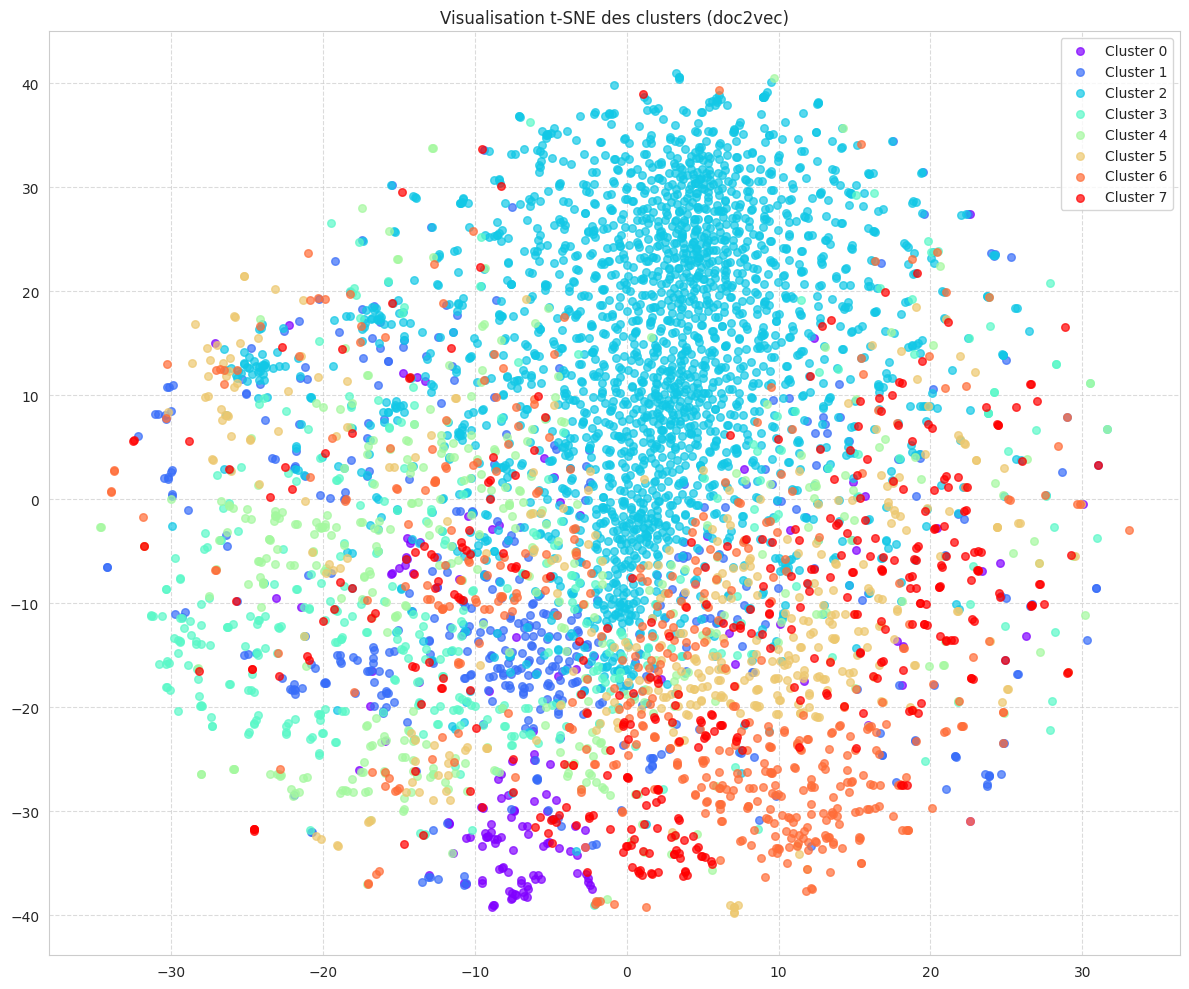

Extraction des termes les plus représentatifs par cluster...
Visualisation des termes les plus représentatifs par cluster...


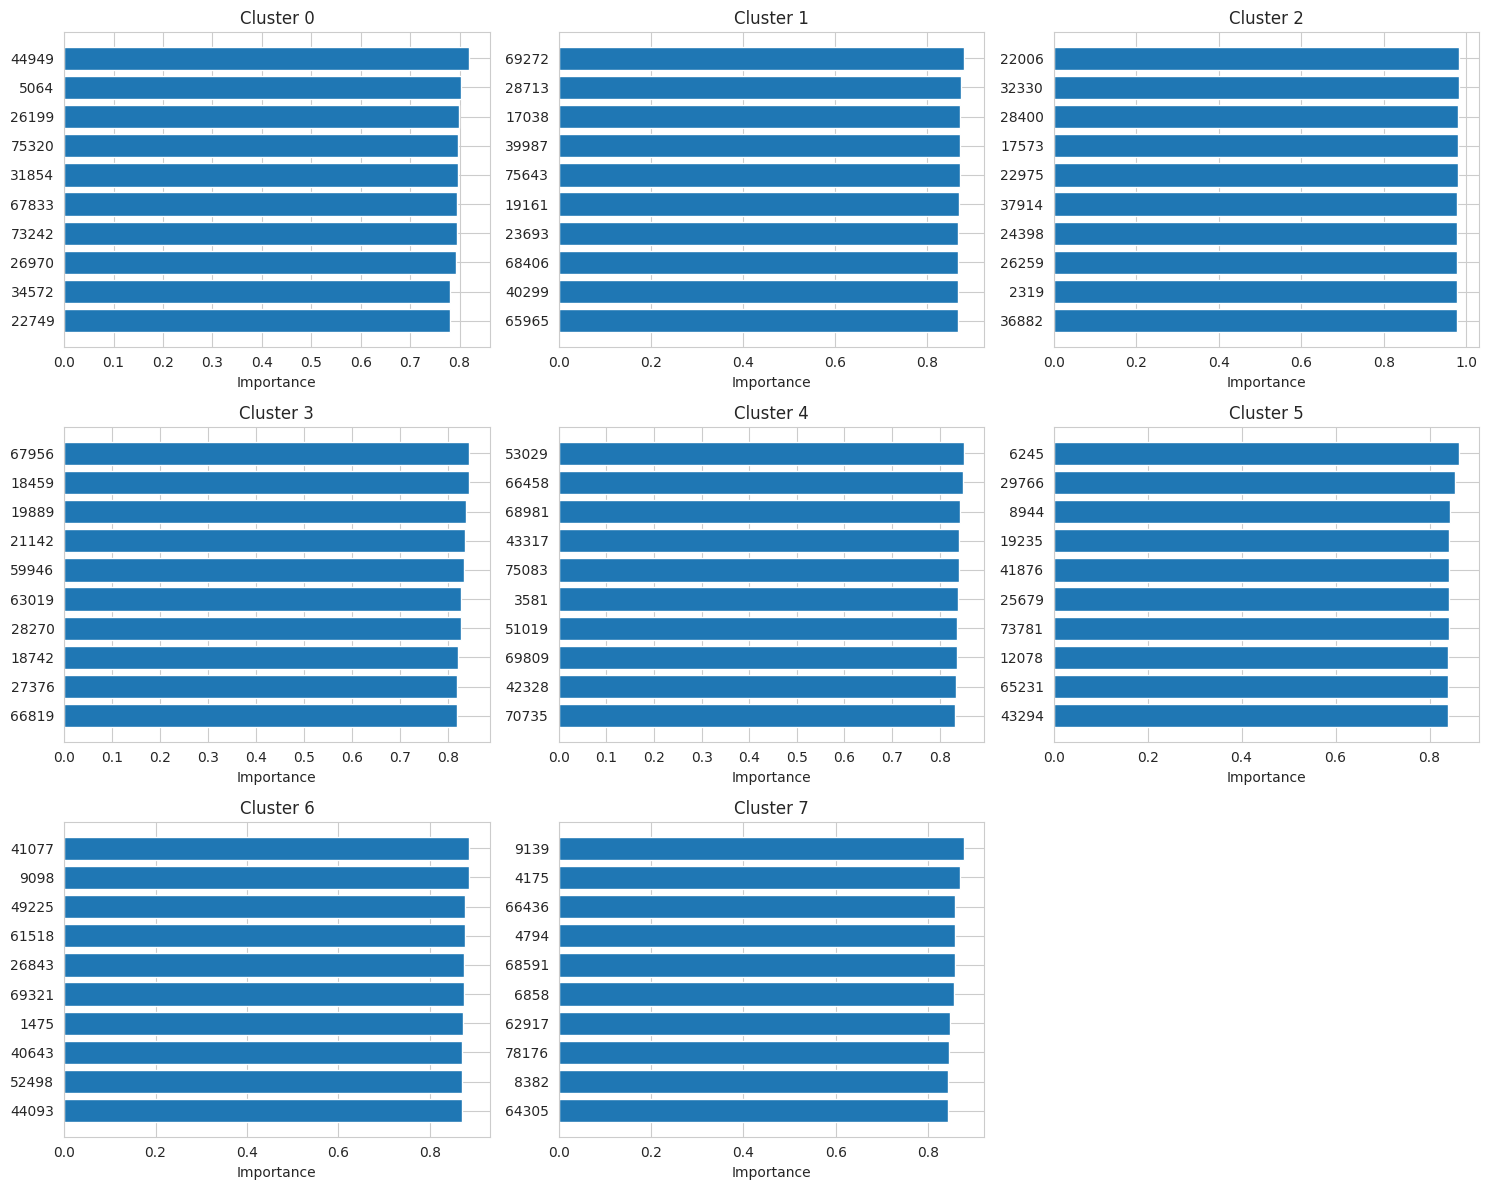

Extraction des documents les plus centraux par cluster...
Documents les plus centraux par cluster:

=== Cluster 0 ===

1. Calcified coronary plaques detection in CTA based-on automatic scale selection and fuzzy C means
   Abstract: Coronary artery diseases are the most common type of heart disease. Early detection and quantification of coronary plaques is therefore of high interest. CTA has rapidly emerged, and is nowadays widel...
   Similarité: 0.7565

2. Feasibility of Using the Optical Sensing Techniques for Early Detection of Huanglongbing in Citrus Seedlings
   Abstract: A vision sensor was introduced and tested for early detection of citrus Huanglongbing (HLB). This disease is caused by the bacterium Candidatus Liberibacter asiaticus (CLas) and is transmitted by the ...
   Similarité: 0.7534

3. Rapid measurement of total non-structural carbohydrate concentration in grapevine trunk and leaf tissues using near infrared spectroscopy
   Abstract: Carbohydrate assays are commonly us

In [12]:
# 4. Analyse des clusters (exemple avec TF-IDF et K-means)
# selon notre meilleur résultat
best_result_key = 'kmeans_8_doc2vec'  # selon nos résultats (ci-dessus)
analyzer = ClusterAnalyzer(
    df,
    vector_rep.vectorizers['doc2vec'],
    clustering.clustering_results[best_result_key]
)

# Visualisation des clusters
analyzer.visualize_clusters_2d(method='tsne')

# Termes les plus représentatifs
top_terms = analyzer.get_top_terms_per_cluster(n_terms=10)
analyzer.visualize_top_terms(top_terms)

# Documents centraux
central_docs = analyzer.get_central_documents(n_docs=3)
analyzer.display_central_documents(central_docs)

In [13]:
# 5. Ajout des étiquettes de cluster au DataFrame
df_with_clusters = clustering.add_cluster_labels_to_df(best_result_key)

# Vérification des clusters
cluster_counts = df_with_clusters[f'cluster_{best_result_key}'].value_counts()
display(cluster_counts)

Étiquettes de cluster ajoutées dans la colonne 'cluster_kmeans_8_doc2vec'.


,count
cluster_kmeans_8_doc2vec,
2,36707
6,8094
1,7407
5,6188
3,6157
4,5989
7,5974
0,2491
